# Kriging
#### Mickey MacKie, Stanford Radio Glaciology

Here we implement simple kriging and ordinary kriging for a case study on Niohalvfjerds-fjorden using variogram parameters from Variogram_model.ipynb. 

Kriging is a deterministic interpolation algorithm. (more coming).



In [1]:
# load dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.neighbors import LocalOutlierFactor
import geostatspy.geostats as geostats 

import GlacierStats as gs

## Load and plot data

In [2]:
df_bed = pd.read_csv('Data/Nioghalvfjerds_bed_data.csv') # download data

# remove outliers with LOF method
clf = LocalOutlierFactor(n_neighbors = 5, contamination = 0.05)
clf.fit_predict(df_bed)
lof = clf.negative_outlier_factor_
df_bed = df_bed[lof >= -1.3]

<function matplotlib.pyplot.show(close=None, block=None)>

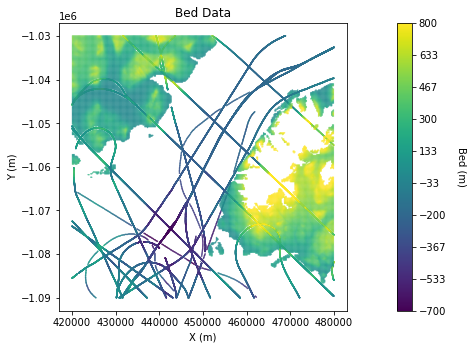

In [3]:
# plot data
im = plt.scatter(df_bed['X'],df_bed['Y'], c = df_bed['Bed'], vmin = -700, vmax = 800, marker=".", s = 0.5)       # scatter plot for location map
plt.title('Bed Data')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-700, 800, 10)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

## Convert to standard Gaussian distribution

In [4]:
df_bed['Nbed'], tvbed, tnsbed = geostats.nscore(df_bed,'Bed')  # normal score transformation

## Set variogram parameters

These are the variogram model parameters we determined in Variogram_model.ipynb:

In [5]:
Azimuth = 22.5 # azimuthal direction of major axis
nug = 0 # nugget
nstruct = 2 # variogram structures
vtype = [1,2] # exponential type (1 = spherical, 2 = exponential, 3 = Guassian)
cc = [0.8,0.2] # contribution for each structure. nugget + cc = 1
a_max = [40000,50000] # major range for each structure
a_min = [25000,30000] # minor range for each structure

vario = [Azimuth, nug, nstruct, vtype, cc, a_max, a_min] # save variogram parameters as a list

## Kriging interpolation

First we need to define a grid to interpolate:

In [6]:
# define coordinate grid
xmin = 420000; xmax = 480000              # range of x values
ymin = -1090000; ymax = -1030000     # range of y values
pix = 500  # pixel resolution
Pred_grid_xy = gs.pred_grid(xmin, xmax, ymin, ymax, pix)

The bed measurement spacing is on the order of tens of meters, which is much finer than the the grid cell spacing. To regularize the kriging estimate, we randomly downsample the data to 10% of its original size

In [7]:
# randomly downsample data to 10% of the original size
df_samp = df_bed.sample(frac=0.10, replace=False, random_state=1)

Then we can perform kriging

In [22]:
k = 100 # number of neighboring data points used to estimate a given point 
rad = 20000 # 20 km search radius
est_SK, var_SK = gs.skrige(Pred_grid_xy, df_samp, 'X', 'Y', 'Nbed', k, vario, rad) # estimation and variance

100%|██████████| 14400/14400 [00:56<00:00, 255.97it/s]


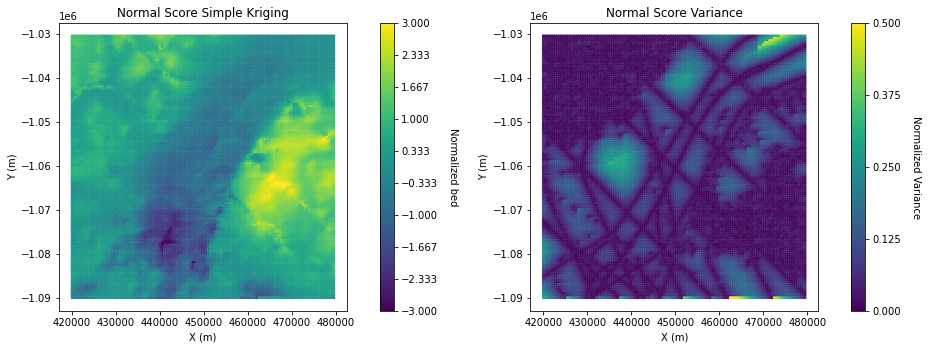

In [23]:
# plot results
plt.subplot(121) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = est_SK, vmin = -3, vmax = 3, marker=".", s = 15)       # scatter plot for location map
plt.title('Normal Score Simple Kriging')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-3, 3, 10)) # add vertical color bar
cbar.set_label("Normalized bed", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplot(122) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = var_SK, vmin = 0, vmax = .5, marker=".", s = 15)       # scatter plot for location map
plt.title('Normal Score Variance')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, .5, 5)) # add vertical color bar
cbar.set_label("Normalized Variance", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

The downside of simple kriging is that it assumes that all the data points are a residual from a constant mean across the area. But this could give us a biased estimate, especially if there are differences in data density at different elevations. Let's try ordinary kriging, which uses a locally varying mean instead.

In [10]:
k = 50
est_OK, var_OK = gs.okrige(Pred_grid_xy, df_samp, 'X', 'Y', 'Nbed', k, vario, rad) # estimation and variance

100%|██████████| 14400/14400 [00:31<00:00, 457.41it/s]


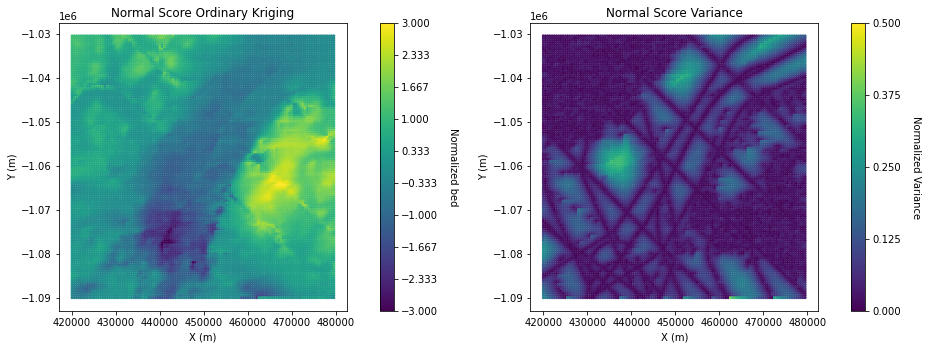

In [11]:
# plot results
plt.subplot(121) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = est_OK, vmin = -3, vmax = 3, marker=".", s = 15)       # scatter plot for location map
plt.title('Normal Score Ordinary Kriging')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-3, 3, 10)) # add vertical color bar
cbar.set_label("Normalized bed", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplot(122) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = var_OK, vmin = 0, vmax = .5, marker=".", s = 15)       # scatter plot for location map
plt.title('Normal Score Variance')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, .5, 5)) # add vertical color bar
cbar.set_label("Normalized Variance", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

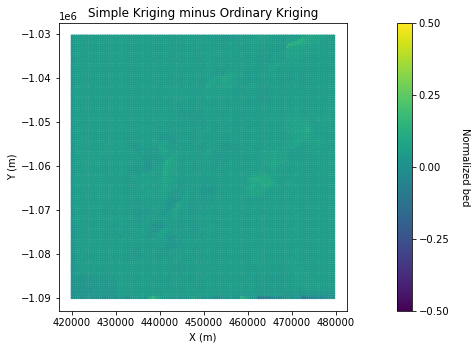

In [19]:
# plot difference
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = est_SK - est_OK, vmin = -0.5, vmax = 0.5, marker=".", s = 15)       # scatter plot for location map
plt.title('Simple Kriging minus Ordinary Kriging')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-0.5, 0.5, 5)) # add vertical color bar
cbar.set_label("Normalized bed", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show()

We can see that there are differences between the two in areas that are not near measurements.

## Reverse normal score transformation

In [20]:
# create dataframes for back transform function
var_OK[var_OK < 0] = 0; # make sure variances are non-negative
std_OK = np.sqrt(var_OK) # convert to standard deviation (this should be done before back transforming)
df_std = pd.DataFrame(std_OK, columns = ['std'])
df_krige = pd.DataFrame(est_OK, columns = ['pred'])

# transformation parameters
vr = tvbed
vrg = tnsbed
ltail = 1
utail = 1
zmin = -4
zmax = 4
ltpar = -1000
utpar = 1000

# transformation
pred_trans = geostats.backtr(df_krige,'pred',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)
std_trans = geostats.backtr(df_std,'std',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

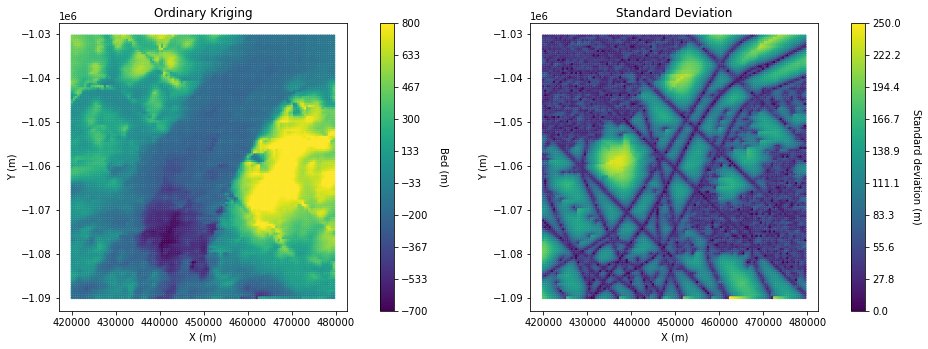

In [21]:
# plot back-transformed results
plt.subplot(121) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = pred_trans, vmin = -700, vmax = 800, marker=".", s = 15)       # scatter plot for location map
plt.title('Ordinary Kriging')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-700, 800, 10)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplot(122)
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = std_trans, vmin = 0, vmax = 250, marker=".", s = 15)       # scatter plot for location map
plt.title('Standard Deviation')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, 250, 10)) # add vertical color bar
cbar.set_label("Standard deviation (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

## Additional considerations

Choose a search radius that is at least the size of the largest measurement gap.

The solution is that the data should be downsampled in a weighted fashion to account for variability in measurement spacing between datasets. 